In [1]:
%run transformer_models.py

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device =  torch.device('cpu') 

def get_data_loaders(batch_size=128, train_subset_size=600, test_subset_size=200):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
    train_subset = Subset(trainset, torch.arange(train_subset_size))
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_subset = Subset(testset, torch.arange(test_subset_size))
    testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader
train_loader, test_loader = get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from transformer_models import VisionTransformer
model = VisionTransformer().to(device)

In [4]:
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Define metrics
num_classes = 10  # For CIFAR-10
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
auc_metric = MulticlassAUROC(num_classes=num_classes).to(device)
f1_metric = MulticlassF1Score(num_classes=num_classes).to(device)
precision_metric = MulticlassPrecision(num_classes=num_classes).to(device)
recall_metric = MulticlassRecall(num_classes=num_classes).to(device)
top1_accuracy_metric = MulticlassAccuracy(num_classes=num_classes, top_k=1).to(device)
top5_accuracy_metric = MulticlassAccuracy(num_classes=num_classes, top_k=5).to(device)

# define function for attention visualization
def attn_viz(image, attention_grid):
    print(image.shape)
    img_size = image.shape[-2:]
    # Create the visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    img_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    ax1.imshow(img_np)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Plot attention heatmap
    im = ax2.imshow(attention_grid.cpu(), cmap='viridis')
    ax2.set_title('Attention Map')
    plt.colorbar(im, ax=ax2)
    ax2.axis('off')
    
    # Plot overlay
    attention_resized = torch.nn.functional.interpolate(
        attention_grid[None, None], 
        size=img_size, 
        mode='bilinear'
    )[0, 0].cpu()
    
    ax3.imshow(img_np)
    ax3.imshow(attention_resized, cmap='viridis', alpha=0.5)
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    return fig


In [5]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    
    # Reset metric values
    accuracy_metric.reset()
    auc_metric.reset()
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    top1_accuracy_metric.reset()
    top5_accuracy_metric.reset()

    for images, labels in dataloader: # Loop through the batches
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(1) # Predictions for metrics like accuracy, F1, precision, and recall
        probs = torch.softmax(outputs, dim=1)  # Probabilities for AUC
        
        # Update metrics
        accuracy_metric.update(preds, labels)
        auc_metric.update(probs, labels)
        f1_metric.update(preds, labels)
        precision_metric.update(preds, labels)
        recall_metric.update(preds, labels)
        top1_accuracy_metric.update(outputs, labels)
        top5_accuracy_metric.update(outputs, labels)

    avg_loss = total_loss / len(dataloader)
    train_accuracy = accuracy_metric.compute()
    train_auc = auc_metric.compute()
    train_f1 = f1_metric.compute()
    train_precision = precision_metric.compute()
    train_recall = recall_metric.compute()
    train_top1_accuracy = top1_accuracy_metric.compute().item()
    train_top5_accuracy = top5_accuracy_metric.compute().item()
    
    return avg_loss, train_accuracy.item(), train_auc.item(), train_f1.item(), train_precision.item(), train_recall.item(), train_top1_accuracy, train_top5_accuracy


def evaluate(model, dataloader, criterion):
    ''' evaluate the model on the test set '''
    model.eval()
    total_loss, correct = 0, 0
    
    # Reset metric values
    accuracy_metric.reset()
    auc_metric.reset()
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    top1_accuracy_metric.reset()
    top5_accuracy_metric.reset()
    img_size, patch_size = 32, 4
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = outputs.argmax(1)
            probs = torch.softmax(outputs, dim=1)  # Probabilities for AUC
            
            # Update metrics
            accuracy_metric.update(preds, labels)
            auc_metric.update(probs, labels)
            f1_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            top1_accuracy_metric.update(outputs, labels)
            top5_accuracy_metric.update(outputs, labels)

    # Get attention weights from the last transformer encoder layer
    last_layer = model.transformer_encoders[-1]
    attention_weights = last_layer.mha.attention_weights[0]  # Get weights from first batch
    
    # Average attention weights across heads
    attention_weights = attention_weights.mean(dim=0)
    
    # Get attention weights for CLS token
    cls_attention = attention_weights[0, 1:]  # Skip CLS token
    
    # Reshape attention weights into a square grid
    num_patches = (img_size // patch_size) ** 2
    attention_grid = cls_attention.reshape(img_size // patch_size,  img_size // patch_size)

    attention_grid = (attention_grid - attention_grid.min()) / (attention_grid.max() - attention_grid.min())

    # Visualize attention weights from last encoder layer
    fig = attn_viz(images[0], attention_grid)
    plt.suptitle(f'Attention Visualization (Class: {labels[0]})')
    plt.show()

    avg_loss = total_loss / len(dataloader)
    val_accuracy = accuracy_metric.compute()
    val_auc = auc_metric.compute()
    val_f1 = f1_metric.compute()
    val_precision = precision_metric.compute()
    val_recall = recall_metric.compute()
    val_top1_accuracy = top1_accuracy_metric.compute().item()
    val_top5_accuracy = top5_accuracy_metric.compute().item()
    
    return avg_loss, val_accuracy.item(), val_auc.item(), val_f1.item(), val_precision.item(), val_recall.item(),  val_top1_accuracy, val_top5_accuracy


torch.Size([3, 32, 32])


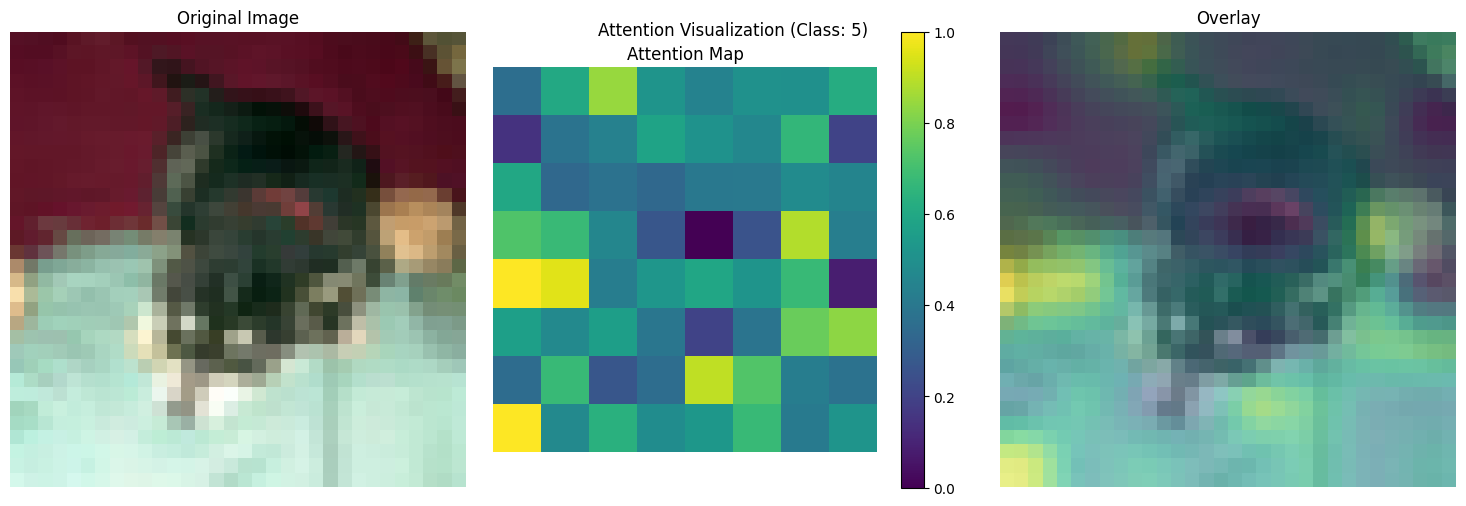

Epoch [1/6] - Train Loss: 2.3741, Train Acc: 0.0955, Train AUC: 0.5018, Train F1: 0.0608, Train Precision: 0.0803, Train Recall: 0.0955,Train Top-1 Acc: 0.0955, Train Top-5 Acc: 0.4873 - Val Loss: 2.2820, Val Acc: 0.1457, Val AUC: 0.6150, Val F1: 0.0682, Val Precision: 0.0915, Val Recall: 0.1457, Val Top-1 Acc: 0.1457, Val Top-5 Acc: 0.5969
torch.Size([3, 32, 32])


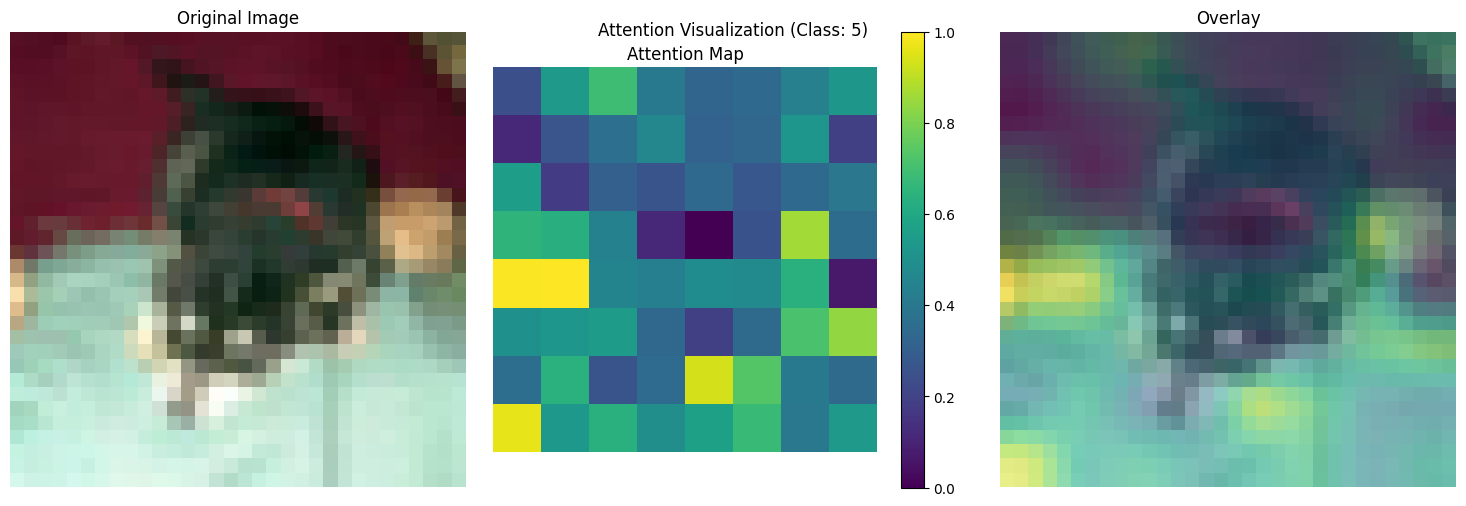

Epoch [2/6] - Train Loss: 2.2525, Train Acc: 0.1578, Train AUC: 0.5973, Train F1: 0.0776, Train Precision: 0.0670, Train Recall: 0.1578,Train Top-1 Acc: 0.1578, Train Top-5 Acc: 0.6011 - Val Loss: 2.2346, Val Acc: 0.1668, Val AUC: 0.6023, Val F1: 0.0755, Val Precision: 0.0532, Val Recall: 0.1668, Val Top-1 Acc: 0.1668, Val Top-5 Acc: 0.5864
torch.Size([3, 32, 32])


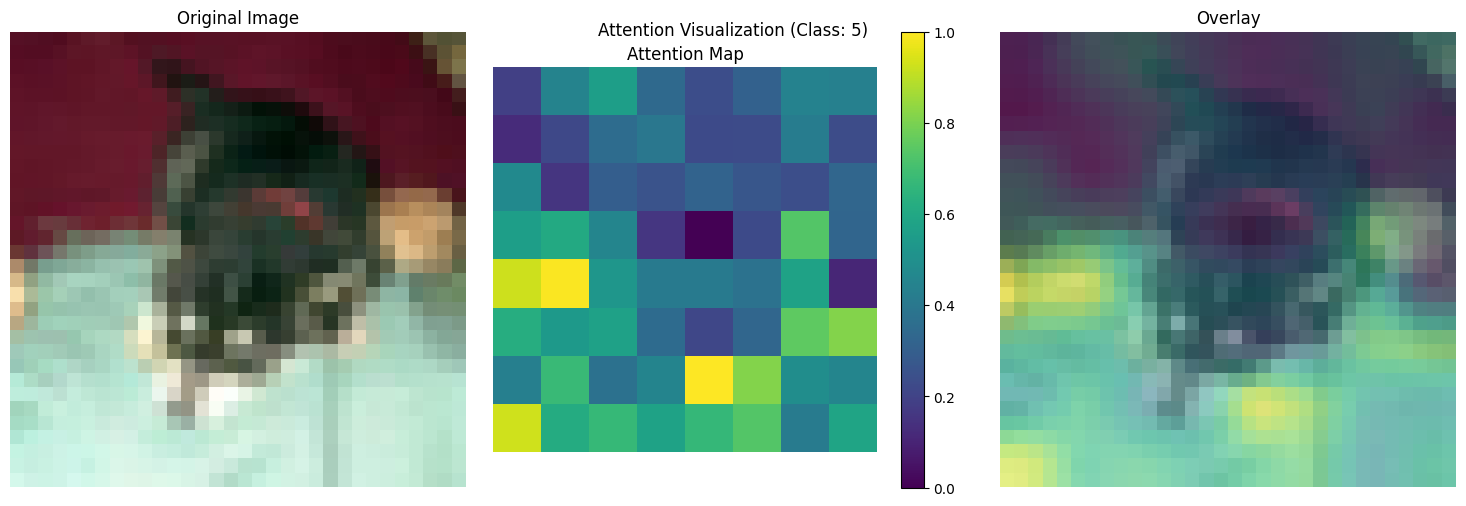

Epoch [3/6] - Train Loss: 2.1929, Train Acc: 0.1842, Train AUC: 0.6246, Train F1: 0.1501, Train Precision: 0.1372, Train Recall: 0.1842,Train Top-1 Acc: 0.1842, Train Top-5 Acc: 0.6534 - Val Loss: 2.1909, Val Acc: 0.1543, Val AUC: 0.6367, Val F1: 0.0839, Val Precision: 0.1048, Val Recall: 0.1543, Val Top-1 Acc: 0.1543, Val Top-5 Acc: 0.6208
torch.Size([3, 32, 32])


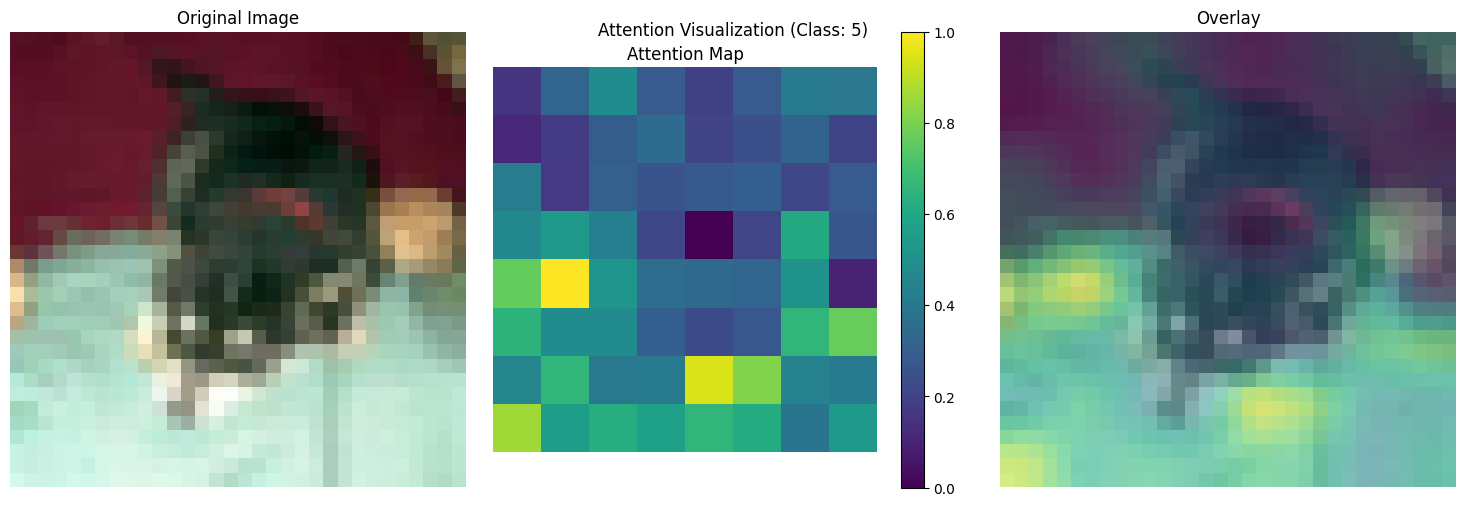

Epoch [4/6] - Train Loss: 2.1436, Train Acc: 0.1995, Train AUC: 0.6583, Train F1: 0.1338, Train Precision: 0.1142, Train Recall: 0.1995,Train Top-1 Acc: 0.1995, Train Top-5 Acc: 0.6971 - Val Loss: 2.1493, Val Acc: 0.2100, Val AUC: 0.6395, Val F1: 0.1293, Val Precision: 0.1026, Val Recall: 0.2100, Val Top-1 Acc: 0.2100, Val Top-5 Acc: 0.6543
torch.Size([3, 32, 32])


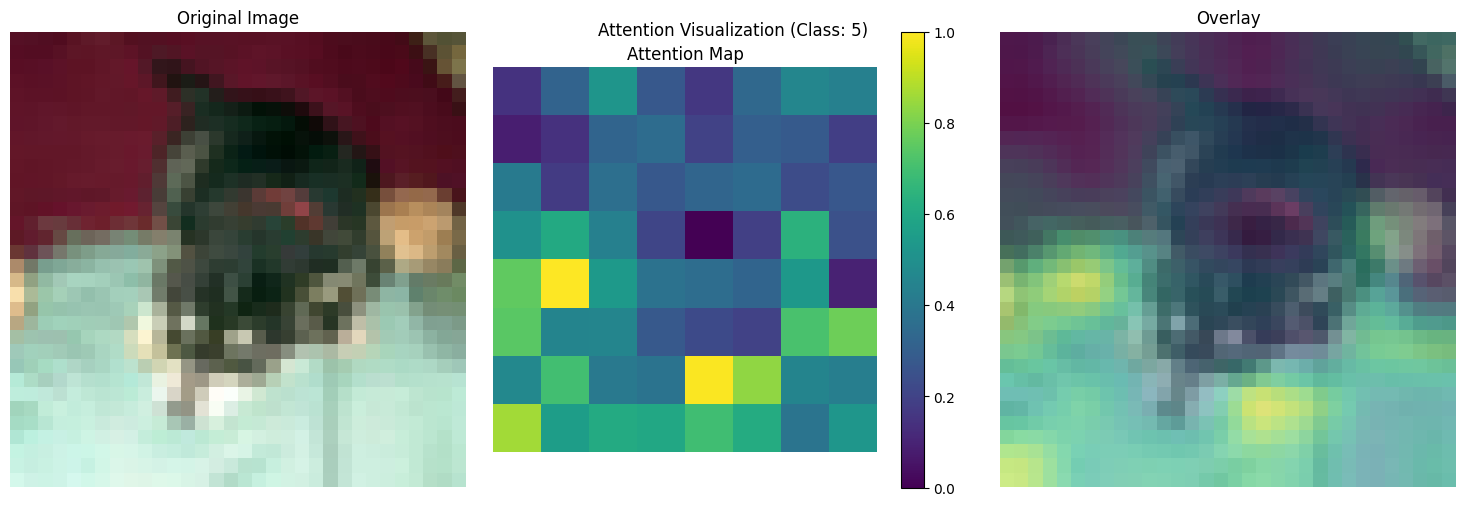

Epoch [5/6] - Train Loss: 2.1034, Train Acc: 0.1910, Train AUC: 0.6696, Train F1: 0.1335, Train Precision: 0.1691, Train Recall: 0.1910,Train Top-1 Acc: 0.1910, Train Top-5 Acc: 0.7130 - Val Loss: 2.1415, Val Acc: 0.1929, Val AUC: 0.6719, Val F1: 0.1234, Val Precision: 0.1085, Val Recall: 0.1929, Val Top-1 Acc: 0.1929, Val Top-5 Acc: 0.6582
torch.Size([3, 32, 32])


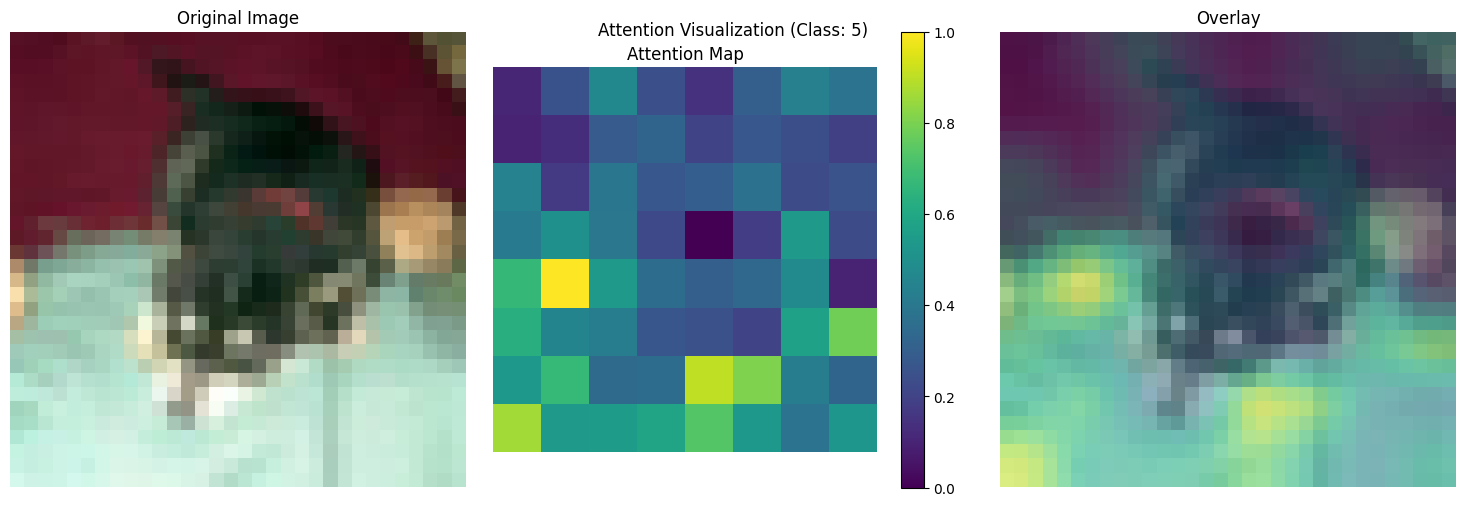

Epoch [6/6] - Train Loss: 2.0789, Train Acc: 0.2027, Train AUC: 0.6847, Train F1: 0.1406, Train Precision: 0.1402, Train Recall: 0.2027,Train Top-1 Acc: 0.2027, Train Top-5 Acc: 0.7253 - Val Loss: 2.1240, Val Acc: 0.2051, Val AUC: 0.6567, Val F1: 0.1545, Val Precision: 0.1337, Val Recall: 0.2051, Val Top-1 Acc: 0.2051, Val Top-5 Acc: 0.6604


In [6]:
# # Hyperparameters
num_epochs = 6
learning_rate = 0.001

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and validation history for all metrics
train_losses, train_accuracies, train_aucs, train_f1s, train_precisions, train_recalls = [], [], [], [], [], []
train_top1_accuracies, train_top5_accuracies = [], []
val_losses, val_accuracies, val_aucs, val_f1s, val_precisions, val_recalls = [], [], [], [], [], []
val_top1_accuracies, val_top5_accuracies = [], []  

# Training the Vision Transformer on CIFAR-10
for epoch in range(num_epochs):
    train_loss, train_accuracy, train_auc, train_f1, train_precision, train_recall, train_top1_accuracy, train_top5_accuracy = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_auc, val_f1, val_precision, val_recall, val_top1_accuracy, val_top5_accuracy = evaluate(model, test_loader, criterion)
    
    # Store history
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_f1s.append(train_f1)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_top1_accuracies.append(train_top1_accuracy)
    train_top5_accuracies.append(train_top5_accuracy)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_f1s.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_top1_accuracies.append(val_top1_accuracy)
    val_top5_accuracies.append(val_top5_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Train AUC: {train_auc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f},"
          f"Train Top-1 Acc: {train_top1_accuracy:.4f}, Train Top-5 Acc: {train_top5_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, "
          f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Top-1 Acc: {val_top1_accuracy:.4f}, "
          f"Val Top-5 Acc: {val_top5_accuracy:.4f}")


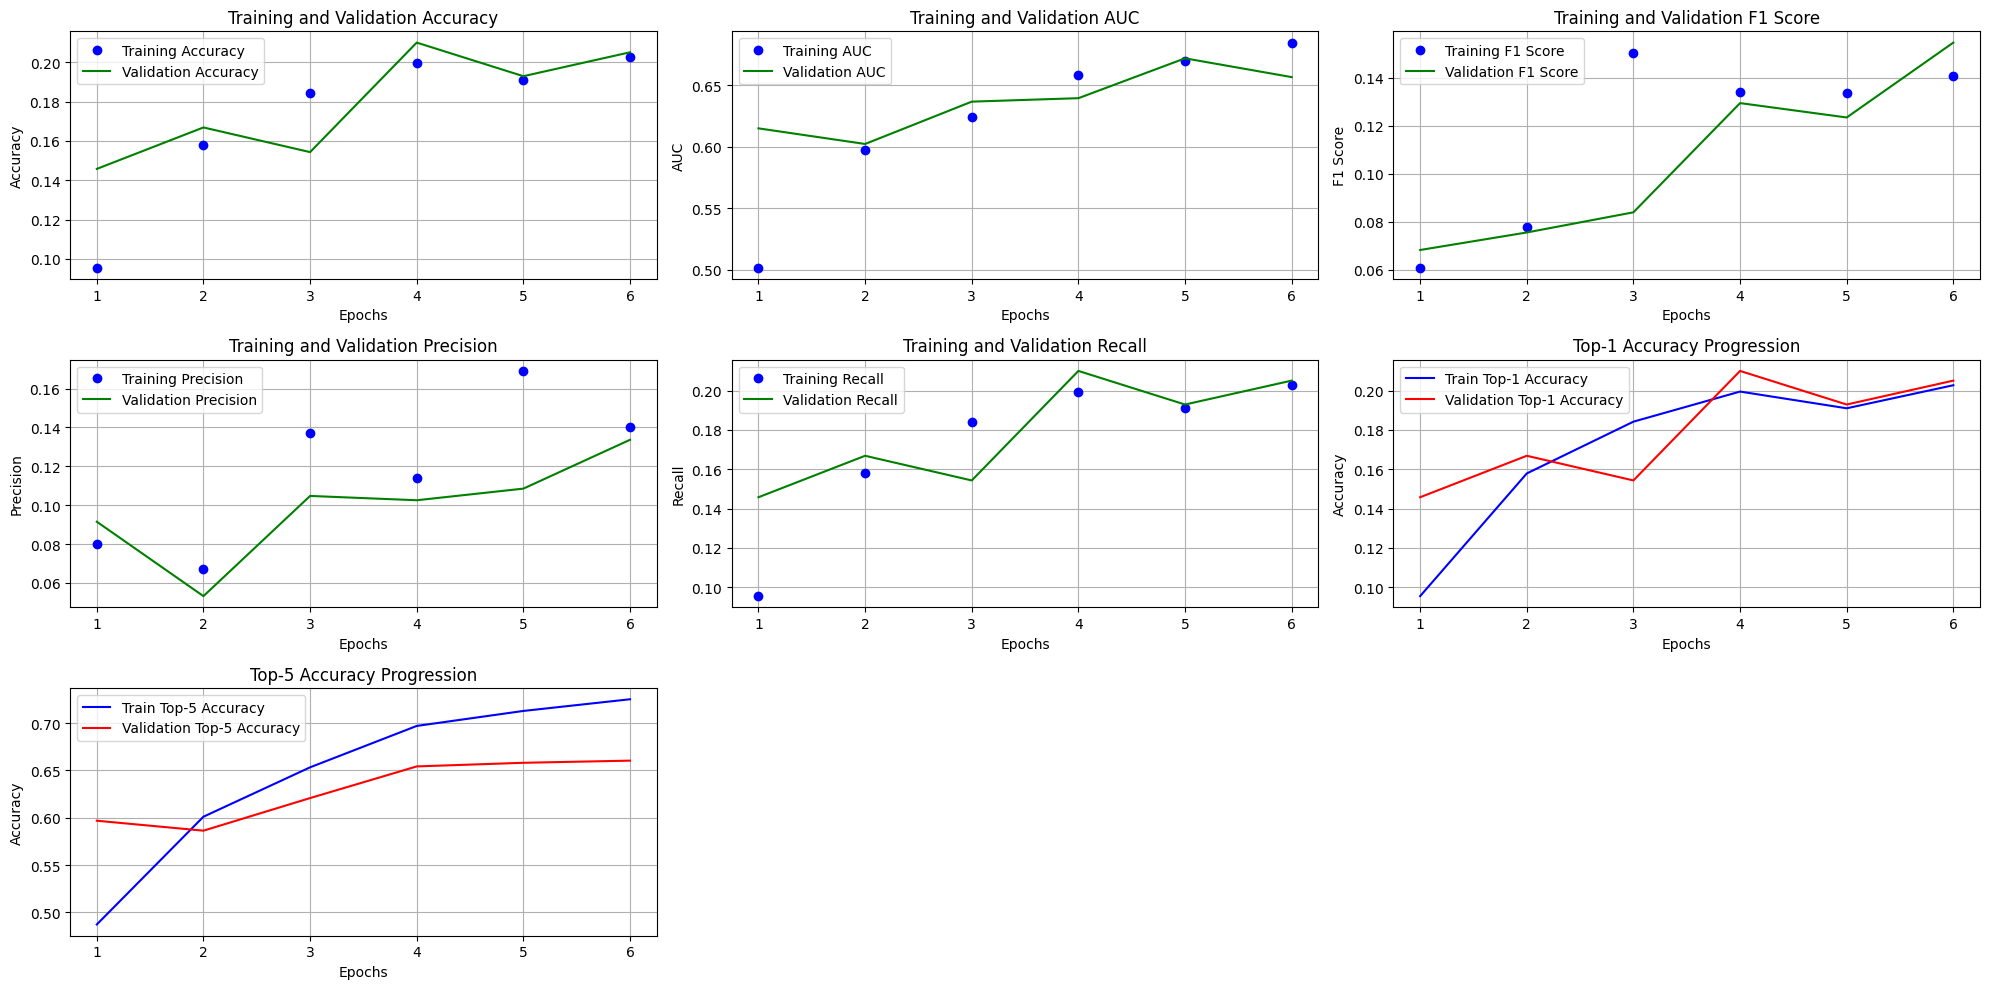

In [7]:
import matplotlib.pyplot as plt

# Plot Accuracy, AUC, F1 Score, Precision, Recall
plt.figure(figsize=(20, 10))

# Plot Accuracy
plt.subplot(3, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'bo', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'g', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot AUC
plt.subplot(3, 3, 2)
plt.plot(range(1, num_epochs + 1), train_aucs, 'bo', label='Training AUC')
plt.plot(range(1, num_epochs + 1), val_aucs, 'g', label='Validation AUC')
plt.title("Training and Validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()

# Plot F1 Score
plt.subplot(3, 3, 3)
plt.plot(range(1, num_epochs + 1), train_f1s, 'bo', label='Training F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1s, 'g', label='Validation F1 Score')
plt.title("Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()

# Plot Precision
plt.subplot(3, 3, 4)
plt.plot(range(1, num_epochs + 1), train_precisions, 'bo', label='Training Precision')
plt.plot(range(1, num_epochs + 1), val_precisions, 'g', label='Validation Precision')
plt.title("Training and Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()

# Plot Recall
plt.subplot(3, 3, 5)
plt.plot(range(1, num_epochs + 1), train_recalls, 'bo', label='Training Recall')
plt.plot(range(1, num_epochs + 1), val_recalls, 'g', label='Validation Recall')
plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(range(1, num_epochs + 1), train_top1_accuracies, 'b-', label='Train Top-1 Accuracy')
plt.plot(range(1, num_epochs + 1), val_top1_accuracies, 'r-', label='Validation Top-1 Accuracy')
plt.title("Top-1 Accuracy Progression")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot Top-5 Accuracy
plt.subplot(3, 3, 7)
plt.plot(range(1, num_epochs + 1), train_top5_accuracies, 'b-', label='Train Top-5 Accuracy')
plt.plot(range(1, num_epochs + 1), val_top5_accuracies, 'r-', label='Validation Top-5 Accuracy')
plt.title("Top-5 Accuracy Progression")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()
